In [1]:
try:
    from openmdao.utils.notebook_utils import notebook_mode
except ImportError:
    !python -m pip install openmdao[notebooks]

# KSComp

KSComp provides a way to aggregate many constraints into a single constraint. This is usually done for performance
reasons, in particular, to reduce the calculation time needed for the total derivatives of your model. The KSComp
implements the Kreisselmeier-Steinhauser Function to aggregate constraint vector input "g" into a single scalar output 'KS'.

By default, the constraint vector "g" is assumed be of the form where g<=0 satisfies the constraints, but other forms can be specified using the "upper" and "lower_flag" options.

The output "KS" should be constrained with an upper-bound of zero to satisfy the aggregated constraint.
By default, it is left to the user to provide this constraint.  However, setting option "add_constraint"
to True will cause the KSComp to automatically add a constraint to the optimization.

## KSComp Options

In [2]:
import openmdao.api as om
om.show_options_table("openmdao.components.ks_comp.KSComp")

Option,Default,Acceptable Values,Acceptable Types,Description
add_constraint,False,"[True, False]",['bool'],"If True, add a constraint on the resulting output of the KSComp. If False, the user will be expected to add a constraint explicitly."
adder,N/A,N/A,"['int', 'float']","Adder for constraint, if added, default is zero."
always_opt,False,"[True, False]",['bool'],"If True, force nonlinear operations on this component to be included in the optimization loop even if this component is not relevant to the design variables and responses."
distributed,False,"[True, False]",['bool'],"If True, set all variables in this component as distributed across multiple processes"
lower_flag,False,"[True, False]",['bool'],Set to True to reverse sign of input constraints.
parallel_deriv_color,N/A,N/A,['str'],"If specified, this design var will be grouped for parallel derivative calculations with other variables sharing the same parallel_deriv_color."
ref,N/A,N/A,"['int', 'float']","Unit reference for constraint, if added, default is one."
ref0,N/A,N/A,"['int', 'float']","Zero-reference for constraint, if added, default is zero."
rho,50.0,N/A,N/A,Constraint Aggregation Factor.
run_root_only,False,"[True, False]",['bool'],"If True, call compute, compute_partials, linearize, apply_linear, apply_nonlinear, and compute_jacvec_product only on rank 0 and broadcast the results to the other ranks."


## KSComp Constructor

The call signature for the `KSComp` constructor is:

```{eval-rst}
    .. automethod:: openmdao.components.ks_comp.KSComp.__init__
        :noindex:
```

## KSComp Example

The following example is perhaps the simplest possible. It shows a component that represents a constraint
of width two. We would like to aggregate the values of this constraint vector into a single scalar
value using the KSComp.

In [3]:
import numpy as np
import openmdao.api as om

prob = om.Problem()
model = prob.model

model.add_subsystem('comp', om.ExecComp('y = 3.0*x',
                                        x=np.zeros((2, )),
                                        y=np.zeros((2, ))), promotes_inputs=['x'])

model.add_subsystem('ks', om.KSComp(width=2))

model.connect('comp.y', 'ks.g')

prob.setup()
prob.set_val('x', np.array([5.0, 4.0]))
prob.run_model()

print(prob.get_val('ks.KS'))

[[15.]]


In [4]:
from openmdao.utils.assert_utils import assert_near_equal

assert_near_equal(prob.get_val('ks.KS'), [[15.0]])

0.0

A more practical example that uses the KSComp can be found in the [beam optimization](../../../examples/beam_optimization_example_part_2) example.

You can also independently aggregate multiple rows of an output as separate constraints by declaring the vec_size argument:

In [5]:
import numpy as np

import openmdao.api as om

prob = om.Problem()
model = prob.model

model.add_subsystem('comp', om.ExecComp('y = 3.0*x',
                                        x=np.zeros((2, 2)),
                                        y=np.zeros((2, 2))), promotes_inputs=['x'])
model.add_subsystem('ks', om.KSComp(width=2, vec_size=2))

model.connect('comp.y', 'ks.g')

prob.setup()
prob.set_val('x', np.array([[5.0, 4.0], [10.0, 8.0]]))
prob.run_model()

print(prob.get_val('ks.KS'))

[[15.]
 [30.]]


In [6]:
assert_near_equal(prob.get_val('ks.KS'), np.array([[15], [30]]))

0.0

## KSComp Option Examples

Normally, the input constraint vector is assumed to be of the form g<=0 is satisfied. If you would like to set a
different upper bound for the constraint, you can declare it in the "upper" option in the options dictionary.

In the following example, we specify a new upper bound of 16 for the constraint vector. Note that the KS output
is still satisfied if it is less than zero.

**upper**

In [7]:
import numpy as np

prob = om.Problem()
model = prob.model

model.add_subsystem('comp', om.ExecComp('y = 3.0*x',
                                        x=np.zeros((2, )),
                                        y=np.zeros((2, ))), promotes_inputs=['x'])
model.add_subsystem('ks', om.KSComp(width=2))

model.connect('comp.y', 'ks.g')

model.ks.options['upper'] = 16.0
prob.setup()
prob.set_val('x', np.array([5.0, 4.0]))
prob.run_model()

print(prob['ks.KS'])

[[-1.]]


In [8]:
assert_near_equal(prob['ks.KS'], np.array([[-1.0]]))

0.0

Normally, the input constraint vector is satisfied if it is negative and violated if it is positive. You can
reverse this behavior by setting the "lower_flag" option to True. In the following example, we turn on the
"lower_flag" so that positive values of the input constraint are considered satisfied. Note that the KS output
is still satisfied if it is less than zero.

**lower_flag**

In [9]:
import numpy as np

prob = om.Problem()
model = prob.model

model.add_subsystem('comp', om.ExecComp('y = 3.0*x',
                                        x=np.zeros((2, )),
                                        y=np.zeros((2, ))), promotes_inputs=['x'])

model.add_subsystem('ks', om.KSComp(width=2))

model.connect('comp.y', 'ks.g')

model.ks.options['lower_flag'] = True
prob.setup()
prob.set_val('x', np.array([5.0, 4.0]))
prob.run_model()

print(prob.get_val('ks.KS'))

[[-12.]]


In [10]:
assert_near_equal(prob.get_val('ks.KS'), [[-12.0]])

0.0

Typically, the KSComp is used to provide a constraint which aggregates many values into a single scalar constraint.
Consider the following simple example, where we seek to maximize the peak of a parabola but also
keep the peak of the parabola below a certain threshold value.  Clearly, the solution here is to have the peak of
the parabola lie on the peak constraint.

Note the resulting value of the offset "k" is not exactly 4.0 as we might expect.  The KS function
provides a differentiable constraint aggregation, but the resulting scalar constraint is slightly
conservative.

**add_constraint**

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.9837172503087404
            Iterations: 2
            Function evaluations: 2
            Gradient evaluations: 2
Optimization Complete
-----------------------------------


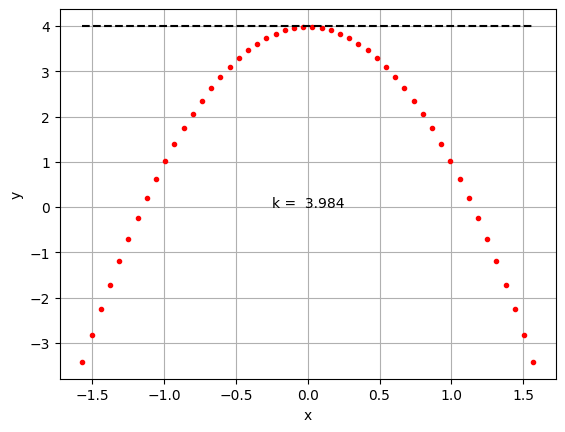

In [11]:
import numpy as np
import matplotlib.pyplot as plt

n = 50
prob = om.Problem()
model = prob.model

prob.driver = om.ScipyOptimizeDriver()

model.add_subsystem('comp', om.ExecComp('y = -3.0*x**2 + k',
                                        x=np.zeros((n, )),
                                        y=np.zeros((n, )),
                                        k=0.0), promotes_inputs=['x', 'k'])

model.add_subsystem('ks', om.KSComp(width=n, upper=4.0, add_constraint=True))

model.add_design_var('k', lower=-10, upper=10)
model.add_objective('k', scaler=-1)

model.connect('comp.y', 'ks.g')

prob.setup()
prob.set_val('x', np.linspace(-np.pi/2, np.pi/2, n))
prob.set_val('k', 5.)

prob.run_driver()

fig, ax = plt.subplots()

x = prob.get_val('x')
y = prob.get_val('comp.y')

ax.plot(x, y, 'r.')
ax.plot(x, 4.0*np.ones_like(x), 'k--')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.grid(True)
ax.text(-0.25, 0, f"k = {prob.get_val('k')[0]:6.3f}")

plt.show()

In [12]:
assert(max(prob.get_val('comp.y')) <= 4.0)

**units**

Finally, note that you can pass a units option to the KSComp that will define units on its input and output variables. There is only one unit, shared between both inputs and outputs.

In [13]:
from openmdao.utils.units import convert_units

n = 10

model = om.Group()

model.add_subsystem('ks', om.KSComp(width=n, units='m'), promotes_inputs=[('g', 'x')])
model.set_input_defaults('x', range(n), units='ft')

prob = om.Problem(model=model)
prob.setup()
prob.run_model()

print(prob.get_val('ks.KS', indices=0))

[2.7432]


In [14]:
assert_near_equal(prob.get_val('ks.KS', indices=0), np.amax(prob.get_val('x')), tolerance=1e-8)

1.7543840396176098e-09

**Example: KSComp for aggregating a constraint with a lower bound.**

When you are using the KSComp to aggregate a constraint with a lower bound, set the "lower_flag"
to True, and it will create a constraint that is satisfied when it is greater than the value
specified in "upper". Because KSComp is a smooth max function, you can pass in any values to
"g" and it will approximate both the min and max.

Optimization terminated successfully    (Exit mode 0)
            Current function value: -10.0
            Iterations: 3
            Function evaluations: 3
            Gradient evaluations: 3
Optimization Complete
-----------------------------------


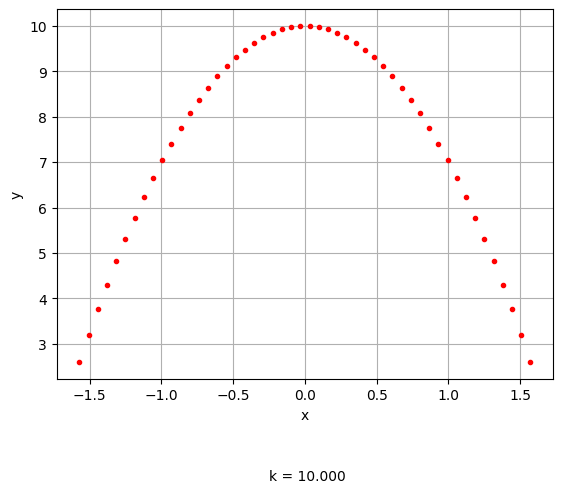

[[-1.58393376]]


In [15]:
import numpy as np
import matplotlib.pyplot as plt

n = 50
prob = om.Problem()
model = prob.model

prob.driver = om.ScipyOptimizeDriver()

model.add_subsystem('comp', om.ExecComp('y = -3.0*x**2 + k',
                                        x=np.zeros((n, )),
                                        y=np.zeros((n, )),
                                        k=0.0), promotes_inputs=['x', 'k'])

model.add_subsystem('ks', om.KSComp(width=n, upper=1.0, lower_flag=True))

model.add_design_var('k', lower=-10, upper=10)
model.add_objective('k', scaler=-1)

model.connect('comp.y', 'ks.g')

prob.setup()
prob.set_val('x', np.linspace(-np.pi/2, np.pi/2, n))
prob.set_val('k', 5.)

prob.run_driver()

fig, ax = plt.subplots()

x = prob.get_val('x')
y = prob.get_val('comp.y')

ax.plot(x, y, 'r.')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.grid(True)
ax.text(-0.25, 0, f"k = {prob.get_val('k')[0]:6.3f}")

plt.show()

print(prob['ks.KS'])

In [16]:
assert(prob['ks.KS'] <= 0)

**Example: KSComp for aggregating a constraint with a non-zero upper bound.**

Here we use the KSComp to aggregate a constraint with an upper bound.

Optimization terminated successfully    (Exit mode 0)
            Current function value: -10.0
            Iterations: 3
            Function evaluations: 3
            Gradient evaluations: 3
Optimization Complete
-----------------------------------


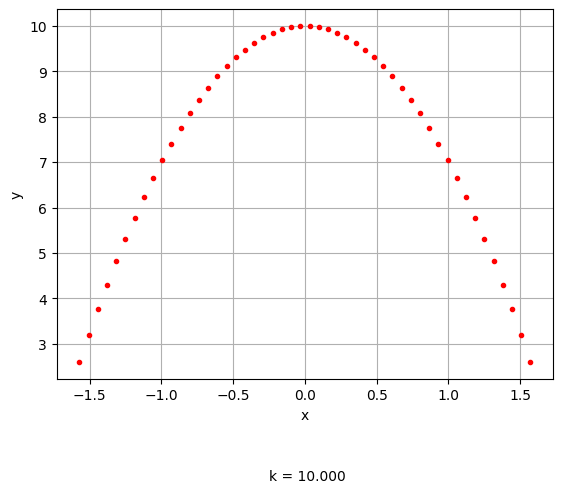

[[-4.98371725]]


In [17]:
import numpy as np
import matplotlib.pyplot as plt

n = 50
prob = om.Problem()
model = prob.model

prob.driver = om.ScipyOptimizeDriver()

model.add_subsystem('comp', om.ExecComp('y = -3.0*x**2 + k',
                                        x=np.zeros((n, )),
                                        y=np.zeros((n, )),
                                        k=0.0), promotes_inputs=['x', 'k'])

model.add_subsystem('ks', om.KSComp(width=n, upper=15.0))

model.add_design_var('k', lower=-10, upper=10)
model.add_objective('k', scaler=-1)

model.connect('comp.y', 'ks.g')

prob.setup()
prob.set_val('x', np.linspace(-np.pi/2, np.pi/2, n))
prob.set_val('k', 5.)

prob.run_driver()

fig, ax = plt.subplots()
x = prob.get_val('x')
y = prob.get_val('comp.y')

ax.plot(x, y, 'r.')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.grid(True)
ax.text(-0.25, 0, f"k = {prob.get_val('k')[0]:6.3f}")

plt.show()

print(prob['ks.KS'])

In [18]:
assert(prob['ks.KS'] <= 0)